<a href="https://colab.research.google.com/github/fredericpoitevin/tseries-deconvolution/blob/master/Deconvolution_of_Michael_coronavirus_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We are interested in the following scenario:
We have access to two cumulative time-series that we call cause (or _cases_ $C(t)$ the total number of cases at time $t$) and consequence (or _deaths_ $D(t) $ the total number of deaths at time $t$). We assume that consequence is cause convolved with an unknown kernel $K$, and we are interested in inferring the kernel function, or at least its parameters.

Formally, 

$$\frac{\partial D}{\partial \tau}|_{\tau=t} = \sum_{s=0}^{t} K(t-s)\frac{\partial C}{\partial \tau}|_{\tau=s}$$

We have access to samples of the cumulative time-series at fixed time intervals $\Delta t$, we can thus discretize the above equation with finite difference. For $i \geq 1$, we introduce $f_{i} = \frac{F(i\Delta t) - F((i-1)\Delta t)}{\Delta t}$:

$$d_{i} = \sum_{j=1}^{i}k_{ij}c_{j}$$

# Illustrative example

## Synthesizing the dataset

First, let's define the parameters below:

In [0]:
ndays            = 50
cases_amplitude  = 100
cases_center     = 15
cases_width      = 5
kernel_amplitude = 0.05
kernel_center    = 5
kernel_width     = 2

Now let's synthesize the cases time-series as well as the kernel. Convolve to predict the deaths, and display the cases and resulting deaths.

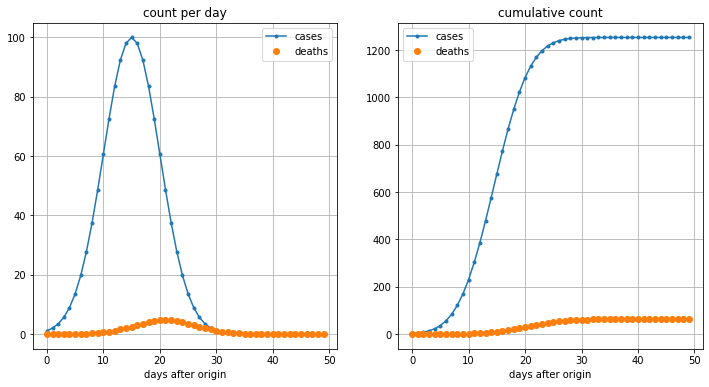

In [115]:
t = define_time_points(ndays)
cases  = synthesize_tseries(t, params=[cases_amplitude,cases_center,cases_width])
kernel = synthesize_tseries(t, params=[kernel_amplitude,kernel_center,kernel_width], normalize=True)
deaths = np.convolve(kernel, cases, mode='same')
display(ndays, c=cases, d=deaths, labels=['cases','deaths'])

## Kernel deconvolution from synthetic data

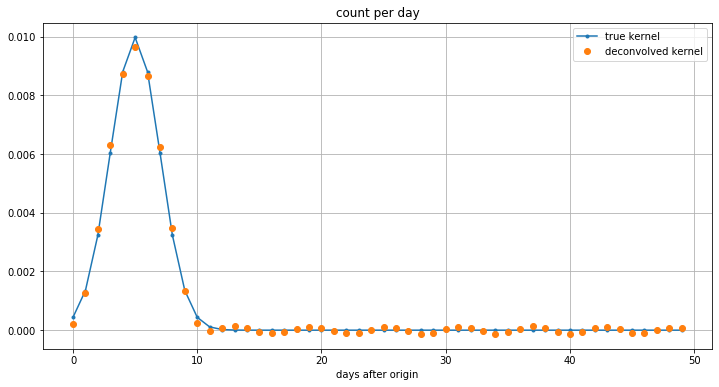

In [116]:
kernel_deconvolved = wiener_deconvolution(ndays, c=cases, d=deaths, nsr=1e-7)
display(ndays, c=kernel, d=kernel_deconvolved, labels=['true kernel','deconvolved kernel'], show_cumul=False)

Let's now measure the discrepancy between the actual and fitted deaths:

>>> RMS = 0.00


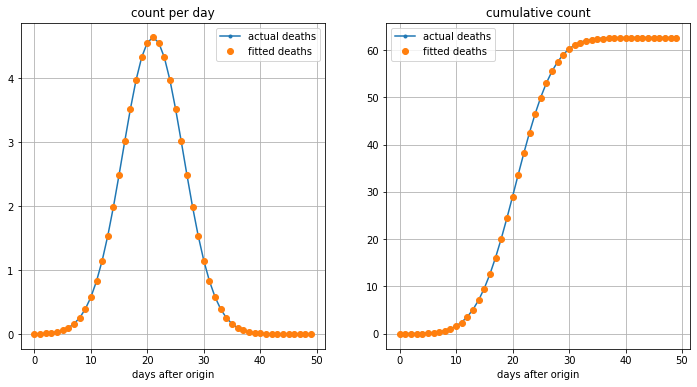

In [117]:
rms = measure_rms(ndays, c=cases, k=kernel_deconvolved, d=deaths)

Let's fit a parametric function to the deconvolved kernel

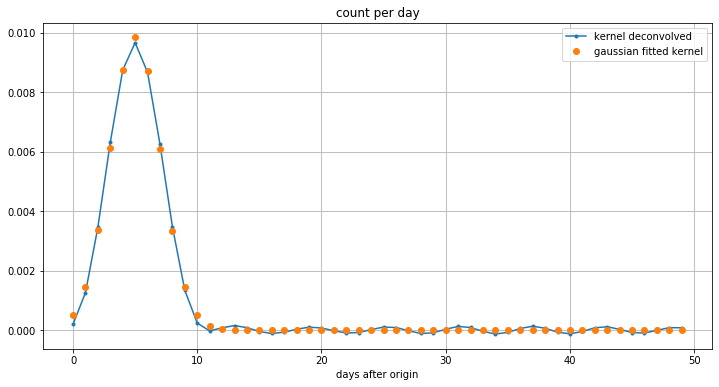

In [122]:
kernel_gaussian_fitted = fit_kernel(kernel_deconvolved, p0=(0.01,ndays+5,5))
display(ndays, c=kernel_deconvolved, d=kernel_gaussian_fitted, 
        labels=['kernel deconvolved','gaussian fitted kernel'], show_cumul=False)


And let's now measure the discrepancy between the actual deaths and the one fitted with the gaussian-fitted kernel:

>>> RMS = 0.11


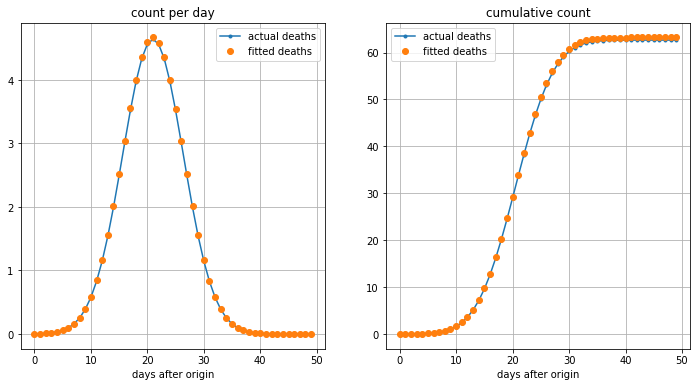

In [123]:
rms = measure_rms(ndays, c=cases, k=kernel_gaussian_fitted, d=deaths)

# Toolkit

In [0]:
# load all libraries
import os
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files
from scipy.optimize import curve_fit

In [0]:
def fit_kernel(kernel, func='gaussian', p0=None):
  """
  """
  if(func=='gaussian'):
    if p0 is None:
      popt, pcov = curve_fit(gaussian, np.arange(kernel.shape[0]), kernel)
    else:
      popt, pcov = curve_fit(gaussian, np.arange(kernel.shape[0]), kernel, p0=p0)
    kernel_fitted = gaussian(np.arange(kernel.shape[0]), popt[0], popt[1], popt[2])
  return kernel_fitted

def measure_rms(ndays, c=None, k=None, d=None, do_display=True, labels=['actual deaths','fitted deaths']):
  """rms
  """
  d_new = np.convolve(k,c,mode='same')
  rms = np.linalg.norm(d_new[ndays:]-d[ndays:])
  print('>>> RMS = {:.2f}'.format(rms))
  if do_display:
    display(ndays, c=d, d=d_new, labels=labels)

def wiener_deconvolution(ndays,c=None,d=None,nsr=0.0):
  """wiener_deconvolution
  """
  c_fft = np.fft.fft(c)
  d_fft = np.fft.fft(d)
  k_fft = d_fft*np.conj(c_fft)/(np.abs(c_fft)**2 + nsr)
  return np.roll(np.real(np.fft.ifft(k_fft)),ndays-1)

def display(ndays,c=None, d=None, labels=['cause', 'consequence'], show_cumul=True):
  ncol=1
  if show_cumul:
    ncol=2
  trange=np.arange(ndays)
  tzero = ndays
  fig = plt.figure(figsize=(12,6))
  plt.subplot(1,ncol,1)
  plt.title('count per day')
  plt.xlabel('days after origin')
  if c is not None:
    plt.plot(trange,c[tzero:], '.-', label=labels[0])
  if d is not None:
    plt.plot(trange,d[tzero:], 'o', label=labels[1])
  plt.grid()
  plt.legend()
  if show_cumul:
    plt.subplot(1,ncol,2)
    plt.title('cumulative count')
    plt.xlabel('days after origin')
    if c is not None:
      plt.plot(trange,np.cumsum(c)[tzero:], '.-', label=labels[0])
    if d is not None:
      plt.plot(trange,np.cumsum(d)[tzero:], 'o', label=labels[1])
    plt.grid()
    plt.legend()

def define_time_points(ndays):
  """define_time_points(ndays)
  """
  return np.arange(-ndays,ndays)

def synthesize_tseries(t, function='gaussian', params=None, normalize=False):
  """synthesize_tseries(t, function='gaussian', params=None, normalize=False)
  Arguments:
  ---------
  - t: time-points (array. Mandatory)
  - function: shape of the distribution (only 'gaussian' is available for now. Optional, gaussian by default)
  - params: parameters of function (optional or mandatory depending on function)
  - normalize: whether function is to be normalized or not.
  Returns:
  -------
  tseries: function evaluated at t
  """
  if(function=='gaussian'):
    if params is None:
      print('WARNING! please provide the following parameters for your gaussian function')
      print('>>>>>>>> gaussian = synthesize_tseries(t, params=[amplitude, origin, width])')
    else:
      tseries = gaussian(t, params[0], params[1], params[2], normalize=normalize)
  else:
    print('WARNING! only gaussian function has been implemented so far...')
    tseries=None
  return tseries

def gaussian(x, amplitude, center, sigma, normalize=False):
  """gaussian(x, amplitude, center, sigma)
  Arguments:
  - x         : data points at which gaussian is evaluated (mandatory)
  - amplitude : mandatory
  - center    : mandatory
  - sigma     : mandatory
  - normalize : if True, rescales amplitude to normalize gaussian
  """
  if normalize:
    amplitude /= np.sqrt(2*np.pi)*sigma
  return amplitude*np.exp(-0.5*((x-center)/sigma)**2)